In [1]:
from src.utils import poses_from_vicon, set_axes_equal, compute_transformation_matrix, apply_transformation, compute_ate, interpolate_to_percentage
import matplotlib.pyplot as plt
import h5py
import numpy as np
np.set_printoptions(precision=3, suppress=True)
%matplotlib widget

from scipy.signal import resample_poly
from scipy.spatial.transform import Rotation

import cv2
import mediapy
from PIL import Image, ImageDraw, ImageFont

### Data Reading & Synchronization

In [2]:
def receive_data(path, trial):
    # Read device poses
    f = h5py.File(f"{path}/{trial}.h5",'r')
    poses = np.array(f['pose_values'])
    color_images = np.array(f['color_images'])
    
    # Read Vicon poses
    vicon_poses = poses_from_vicon(f"{path}/{trial}.csv")
    up = 3  
    down = 10 
    vicon_poses_downsampled = resample_poly(vicon_poses, up, down)
    
    # Loop through all possible starting points and find the one with the lowest ATE
    frame_diff = len(vicon_poses_downsampled)-len(poses)    
    best_idx = 0
    best_ate = 1e9
    for idx in range(frame_diff):
        vicon_poses_cropped = vicon_poses_downsampled[idx:idx+len(poses)]
        R_optimal, t_optimal = compute_transformation_matrix(poses, vicon_poses_cropped)
        aligned_estimated_poses = apply_transformation(poses, R_optimal, t_optimal) 
        ate = compute_ate(aligned_estimated_poses, vicon_poses_cropped)
    
        if ate < best_ate:
            best_ate = ate
            best_idx = idx

    vicon_poses_final = vicon_poses_downsampled[best_idx:best_idx+len(poses)]
    
    R_optimal, t_optimal = compute_transformation_matrix(poses, vicon_poses_final)
    print(R_optimal, t_optimal)
    aligned_poses = apply_transformation(poses, R_optimal, t_optimal) 
    
    print(f"{trial} - best ATE {best_ate:.4f} at index {best_idx}")
    
    return aligned_poses, vicon_poses_final, color_images 

In [3]:
poses1, vicon_poses1, video1 = receive_data(path="/Users/jannik/Repos/demonstration-interface/data/session_20240620_142739_smoothing", trial="trial1")
poses2, vicon_poses2, video2 = receive_data(path="/Users/jannik/Repos/demonstration-interface/data/session_20240620_142739_smoothing", trial="trial2")
poses3, vicon_poses3, video3 = receive_data(path="/Users/jannik/Repos/demonstration-interface/data/session_20240620_142739_smoothing", trial="trial3")
poses4, vicon_poses4, video4 = receive_data(path="/Users/jannik/Repos/demonstration-interface/data/session_20240620_142739_smoothing", trial="trial4")

[[ 0.032 -0.832 -0.554]
 [ 0.145 -0.544  0.826]
 [-0.989 -0.107  0.104]] [0.229 0.057 0.685]
trial1 - best ATE 0.0333 at index 24
[[-0.004 -0.874 -0.485]
 [ 0.215 -0.475  0.854]
 [-0.977 -0.101  0.19 ]] [0.228 0.013 0.77 ]
trial2 - best ATE 0.0255 at index 19
[[ 0.006 -0.819 -0.573]
 [ 0.169 -0.564  0.808]
 [-0.986 -0.102  0.135]] [0.204 0.017 0.784]
trial3 - best ATE 0.0265 at index 19
[[-0.093 -0.866 -0.492]
 [ 0.257 -0.498  0.828]
 [-0.962 -0.049  0.268]] [0.213 0.024 0.748]
trial4 - best ATE 0.0311 at index 13


### Manual Seperation of Episodes

In [4]:
def annotate_and_show(video):
    annotated_frames = []
    for idx, frame in enumerate(video):    
        img = Image.fromarray(frame)
        draw = ImageDraw.Draw(img)
        draw.text((20, 20), str(idx), fill=(255, 255, 255))
        annotated_frames.append(np.array(img))
    
    mediapy.show_video(annotated_frames, fps=30)
# annotate_and_show(video4)

In [5]:
episode1_indices = range(0,155)
episode2_indices = range(260,460)
episode3_indices = range(550,719)

episode4_indices = range(0,179)
episode5_indices = range(280,406)
episode6_indices = range(510,683)

episode7_indices = range(0,233)
episode8_indices = range(325,535)
episode9_indices = range(700,928)

episode10_indices = range(25,220)
episode11_indices = range(330,535)
episode12_indices = range(640,840)

In [6]:
cleaned_poses = [
    poses1[episode1_indices],
    poses1[episode2_indices],
    poses1[episode3_indices],
    poses2[episode4_indices],
    poses2[episode5_indices],
    poses2[episode6_indices],
    poses3[episode7_indices],
    poses3[episode8_indices],
    poses3[episode9_indices],
    poses4[episode10_indices],
    poses4[episode11_indices],
    poses4[episode12_indices]
]

cleaned_vicon_poses = [
    vicon_poses1[episode1_indices],
    vicon_poses1[episode2_indices],
    vicon_poses1[episode3_indices],
    vicon_poses2[episode4_indices],
    vicon_poses2[episode5_indices],
    vicon_poses2[episode6_indices],
    vicon_poses3[episode7_indices],
    vicon_poses3[episode8_indices],
    vicon_poses3[episode9_indices],
    vicon_poses4[episode10_indices],
    vicon_poses4[episode11_indices],
    vicon_poses4[episode12_indices]
]

cleaned_videos = [
    video1[episode1_indices],
    video1[episode2_indices],
    video1[episode3_indices],
    video2[episode4_indices],
    video2[episode5_indices],
    video2[episode6_indices],
    video3[episode7_indices],
    video3[episode8_indices],
    video3[episode9_indices],
    video4[episode10_indices],
    video4[episode11_indices],
    video4[episode12_indices]
]

In [7]:
#mediapy.show_videos(cleaned_videos, fps=30, columns=4, width=300)

### Interpolate to [0,100] % Episode Completion Axis

In [8]:
abs_errors = []
abs_pos_errors = []
abs_rot_errors = []

for i in range(len(cleaned_poses)):
    abs_error = np.abs(cleaned_poses[i] - cleaned_vicon_poses[i])
    abs_error_interpolated = interpolate_to_percentage(abs_error)

    abs_rot_errors.append(
        interpolate_to_percentage(
            np.abs(
                Rotation.from_matrix(cleaned_poses[i][:, :3, :3]).as_euler("xyz", degrees=True)
                - Rotation.from_matrix(cleaned_vicon_poses[i][:, :3, :3]).as_euler("xyz", degrees=True
                )
            )
        )
    )

    abs_pos_errors.append(abs_error_interpolated[:, :3, 3] * 1000)

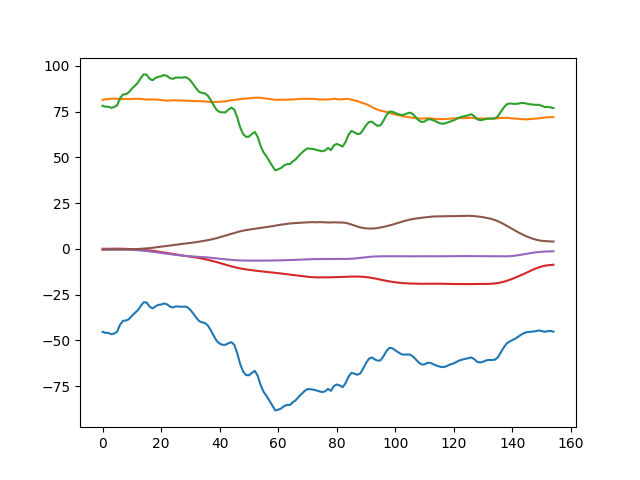

In [9]:
plt.figure()
plt.plot(Rotation.from_matrix(cleaned_poses[0][:, :3, :3]).as_euler("xyz", degrees=True))
plt.plot(Rotation.from_matrix(cleaned_vicon_poses[0][:, :3, :3]).as_euler("xyz", degrees=True))
plt.show()

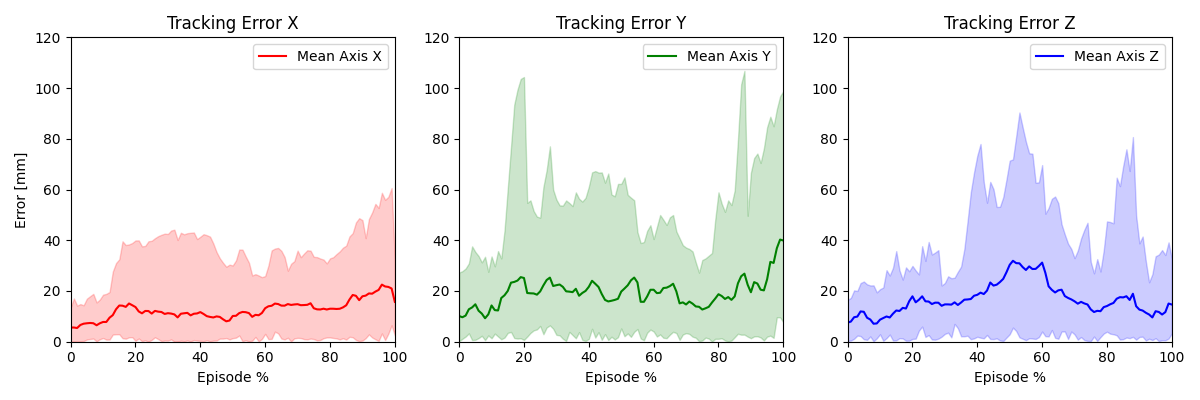

In [10]:
mean_errors = np.mean(abs_pos_errors, axis=0)
min_errors = np.min(abs_pos_errors, axis=0)
max_errors = np.max(abs_pos_errors, axis=0)

axis_labels = ['X', 'Y', 'Z']
colors = ['r', 'g', 'b']

fig, axs = plt.subplots(1, 3, figsize=(12, 4)) 
for i in range(3):
    axs[i].plot(mean_errors[:,i], label=f'Mean Axis {axis_labels[i]}', color=colors[i])
    axs[i].fill_between(range(101), min_errors[:,i], max_errors[:,i], color=colors[i], alpha=0.2)
    axs[i].set_xlabel('Episode %')
    axs[i].set_title(f'Tracking Error {axis_labels[i]}')
    axs[i].legend()
    axs[i].set_ylim(0, 120)
    axs[i].set_xlim(0, 100)
axs[0].set_ylabel('Error [mm]')
plt.tight_layout() 
plt.show()

### Pose Alignment & Error Calculation

In [11]:
# Compute RMSE for translation components
for i in range(len(cleaned_poses)):
    print(f'#####Episode{i+1}#####')
    rmse_translation = np.sqrt(np.mean((cleaned_poses[i][:, :3, 3] - cleaned_vicon_poses[i][:, :3, 3])**2))
    print(f'RMSE: {rmse_translation*1000:.2f}mm')

    ate = compute_ate(cleaned_poses[i], cleaned_vicon_poses[i])
    print(f'ATE:  {ate*1000:.2f}mm')

#####Episode1#####
RMSE: 20.16mm
ATE:  28.26mm
#####Episode2#####
RMSE: 24.64mm
ATE:  38.55mm
#####Episode3#####
RMSE: 28.79mm
ATE:  42.75mm
#####Episode4#####
RMSE: 15.26mm
ATE:  23.52mm
#####Episode5#####
RMSE: 14.68mm
ATE:  23.22mm
#####Episode6#####
RMSE: 24.73mm
ATE:  38.36mm
#####Episode7#####
RMSE: 22.57mm
ATE:  34.24mm
#####Episode8#####
RMSE: 15.21mm
ATE:  21.94mm
#####Episode9#####
RMSE: 21.92mm
ATE:  35.00mm
#####Episode10#####
RMSE: 20.99mm
ATE:  30.32mm
#####Episode11#####
RMSE: 17.37mm
ATE:  27.44mm
#####Episode12#####
RMSE: 33.55mm
ATE:  50.35mm


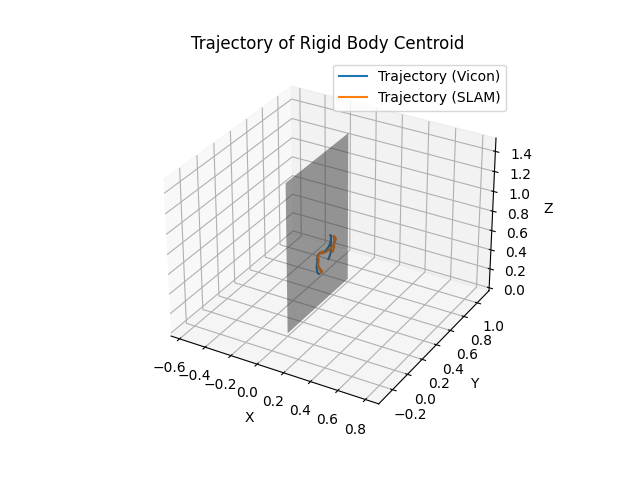

In [12]:
# Visualize the trajectory of the centroid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

### TABLE ###
y = np.linspace(0, 0.8, 100)
z = np.linspace(0, 1.5, 100)
Y, Z = np.meshgrid(y, z)
X = np.full_like(Y, 0)
ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, color='grey')

ax.plot(cleaned_vicon_poses[0][:,0,3],cleaned_vicon_poses[0][:,1,3],cleaned_vicon_poses[0][:,2,3], label='Trajectory (Vicon)')
ax.plot(cleaned_poses[0][:,0,3],cleaned_poses[0][:,1,3],cleaned_poses[0][:,2,3], label='Trajectory (SLAM)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')



set_axes_equal(ax)
ax.set_title('Trajectory of Rigid Body Centroid')
plt.legend()
plt.show()

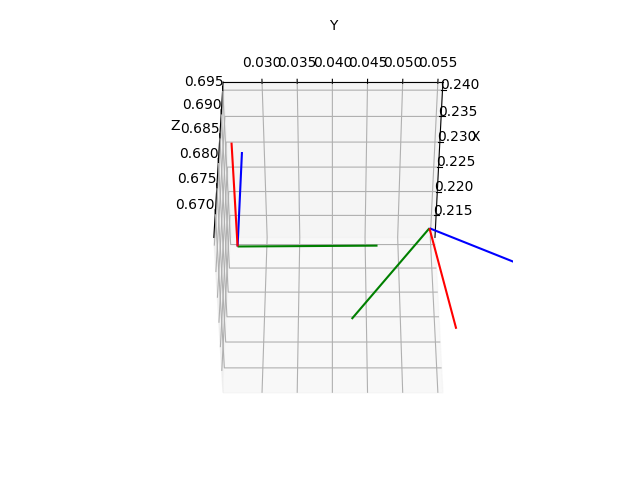

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')    
ax.set_box_aspect([1.0, 1.0, 1.0])


poses_to_plot = cleaned_vicon_poses[0][:1]
poses_to_plot2 = cleaned_poses[0][:1]

for i in range(len(poses_to_plot2)):
    t = poses_to_plot[i,:3, 3]
    R = poses_to_plot[i,:3, :3]
    ax.quiver(t[0], t[1], t[2], R[0, 0], R[1, 0], R[2, 0], length=0.02, color='r', arrow_length_ratio=0)
    ax.quiver(t[0], t[1], t[2], R[0, 1], R[1, 1], R[2, 1], length=0.02, color='g', arrow_length_ratio=0)
    ax.quiver(t[0], t[1], t[2], R[0, 2], R[1, 2], R[2, 2], length=0.02, color='b', arrow_length_ratio=0)

    t = poses_to_plot2[i,:3, 3]
    R = poses_to_plot2[i,:3, :3]
    ax.quiver(t[0], t[1], t[2], R[0, 0], R[1, 0], R[2, 0], length=0.02, color='r', arrow_length_ratio=0)
    ax.quiver(t[0], t[1], t[2], R[0, 1], R[1, 1], R[2, 1], length=0.02, color='g', arrow_length_ratio=0)
    ax.quiver(t[0], t[1], t[2], R[0, 2], R[1, 2], R[2, 2], length=0.02, color='b', arrow_length_ratio=0)

    
# ax.quiver(0,0,0, 1, 0, 0, length=0.3, color='r', arrow_length_ratio=0)    
# ax.quiver(0,0,0, 0,1,0, length=0.3, color='g', arrow_length_ratio=0)
# ax.quiver(0,0,0, 0,0,1, length=0.3, color='b', arrow_length_ratio=0)

# TABLE
# y = np.linspace(0, 0.8, 100)
# z = np.linspace(0, 1.5, 100)
# Y, Z = np.meshgrid(y, z)
# X = np.full_like(Y, 0)
# ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, color='grey')

    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
    
ax.grid(True)
ax.view_init(elev=-45, azim=0, roll=0)

set_axes_equal(ax)
plt.show()